Import necessary libraries and functions

In [4]:
import numpy as np, cmath, scipy as sp
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import *
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert

from matplotlib.pyplot import *

%matplotlib inline

Import optional library for pretty plots

In [5]:
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

load the sample EEG data

In [6]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

Figure 18.1

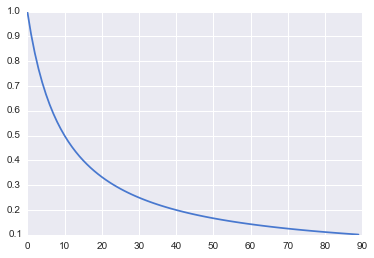

In [12]:

# 1/f function
c = 1
x = 1

plot(c/np.arange(1,10,.1)**x)

Figure 18.2

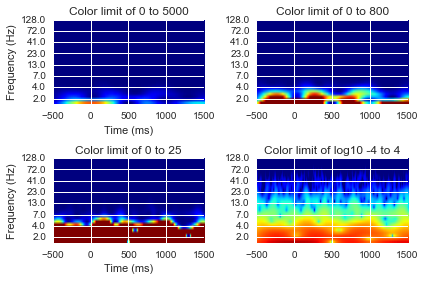

In [81]:
#wavelet parameters
min_freq = 2
max_freq = 128
num_frex = 30

#other wavelet parameters
frequencies = logspace(log10(min_freq),log10(max_freq),num_frex)
time = np.arange(-1,1+1/EEGsrate,1/EEGsrate)
half_of_wavelet_size = (len(time)-1)/2

def nextpow2(n):
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i


#FFT parameters (use next-power-of-2)
n_wavelet     = len(time)
n_data        = EEGpnts;
n_convolution = n_wavelet+n_data-1;
n_conv_pow2   = int(nextpow2(n_convolution))
wavelet_cycles= 4

#FFT of data (note: this doesn't change on frequency iteration)
fft_data = fft(squeeze(EEGdata[22,:,0]),n_conv_pow2)

#initialize output time-frequency data
tf_data = zeros([len(frequencies),EEGpnts])


for fi in xrange(len(frequencies)):
    
    #create wavelet and get its FFT
    wavelet = (pi*frequencies[fi]*sqrt(pi))**(-.5) * exp(2*1j*pi*frequencies[fi]*time)* exp(-time**2/(2*( wavelet_cycles /(2*pi*frequencies[fi]))**2))/frequencies[fi]                                                                                                 
                                                                                                      
    fft_wavelet = fft(wavelet,n_conv_pow2)
    
    #run convolution
    convolution_result_fft = ifft(fft_wavelet*fft_data,n_conv_pow2)
    convolution_result_fft = convolution_result_fft[:n_convolution] # note: here we remove the extra points from the power-of-2 FFT
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    
    #put power data into time-frequency matrix
    tf_data[fi,:] = np.abs(convolution_result_fft)**2
    
    
ytickskip = np.arange(2,num_frex+4,4)# This will be explained in the text.

subplot(221)
imshow(tf_data,origin="lower",aspect="auto",
       cmap=cm.jet, vmin=0, vmax=5000,
       extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
xlabel('Time (ms)')
ylabel('Frequency (Hz)')
title('Color limit of 0 to 5000') 

subplot(222)
imshow(tf_data,origin="lower",aspect="auto"
       ,cmap=cm.jet, vmin=0, vmax=800,
      extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Color limit of 0 to 800') 

subplot(223)
imshow(tf_data,origin="lower",aspect="auto"
       ,cmap=cm.jet, vmin=0, vmax=25,
      extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Color limit of 0 to 25') 
xlabel('Time (ms)')
ylabel('Frequency (Hz)')

subplot(224)
imshow(log10(tf_data),origin="lower",aspect="auto"
       ,cmap=cm.jet, vmin=-4, vmax=4,
      extent=[-500,1500,0,30])
plt.setp(plt.gca(),'yticks',ytickskip,'yticklabels',np.round(frequencies[ytickskip-1]),'xlim',[-500, 1500])
title('Color limit of log10 -4 to 4') 

tight_layout()

Figure 18.3

(30, 640)

<matplotlib.contour.QuadContourSet instance at 0x113988a70>

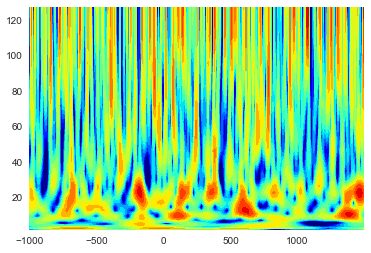

In [109]:
# define baseline period
baselinetime = np.array([ -500, -200 ])

baselineidx =np.zeros(2)

# convert baseline window time to indices
baselineidx[0]=argmin(np.abs(EEGtimes-baselinetime[0]))
baselineidx[1]=argmin(np.abs(EEGtimes-baselinetime[1]))


#dB-correct
baseline_power = mean(tf_data[:,baselineidx[0]:baselineidx[1]],axis=1)
dbconverted = 10*log10( tf_data/np.reshape(baseline_power,[len(baseline_power),1]))
# FYI: the following lines of code are equivalent to the previous line:
# dbconverted = 10*( bsxfun(@minus,log10(tf_data),log10(baseline_power)));
# dbconverted = 10*log10( tf_data ./ repmat(baseline_power,1,EEG.pnts) );
# dbconverted = 10*( log10(tf_data) - log10(repmat(baseline_power,1,EEG.pnts)) );


contourf(EEGtimes,frequencies,dbconverted,40,vmin=-12,vmax=12,cmap=cm.jet)
# setp(gca(),'yticks',np.round(logspace(log10(frequencies[0]),log10(frequencies[-1])*100)/100))
                          
# title('Color limit of -12 to +12 dB')

Figure 18.4

In [ ]:
time2plot = 300 # in ms


timeidx = argmin(np.abs(EEGtimes-time2plot))


subplot(211)
plot(frequencies,tf_data[:,timeidx])
title( 'Power spectrum at ' + str(EEGtimes[timeidx]) + ' ms' )
ylabel('Raw power (\muV^2)')
xlabel('Frequency (Hz)')

subplot(212)
plot(frequencies,dbconverted[:,timeidx])
ylabel('Baseline-normalized power (dB)')
xlabel('Frequency (Hz)')
